All marks in range(0, 9)

# Single datasets preprocessing

## Tg comedy dataset

Dataset built manually from telegram comedy channel. It contains setups and different punches from different autors.
Every punch has number of likes, which tell us about it quality.

In [2]:
import os
from glob import glob
import re
import pandas as pd

from tqdm import tqdm
tqdm.pandas()

### Create .txt files

### Convert .txt files to .tsv

In [ ]:
df = pd.DataFrame()
pattern = r"(.+)\,\s\[.*\]\:\n(.+)"

for filepath in glob('../data/comedy-news-tg-dataset/jokes*.txt'):
    
    if os.path.getsize(filepath) == 0:
        continue
        
    filenum = re.search('\d+', filepath)[0]
    print(filepath, end=', size: ')
    
    with open(filepath) as f:
        setup = f.readline().replace('\xa0', ' ').strip()[:-1]
        
        raw_jokes = f.read().replace('\xa0', ' ').strip()
        raw_jokes = re.sub(r'(Н|н)овость(\W|\n)*', '', raw_jokes)
        raw_jokes = re.sub(f'{setup}(\W|\n)*', '', raw_jokes)
        
    parsed = re.findall(pattern, raw_jokes)
    temp_df = pd.DataFrame(parsed, columns=['author', 'punch'])
    temp_df['setup'] = setup
    temp_df['mark'] = None
    
    temp_df = temp_df[['setup', 'author', 'punch', 'mark']]
    
    temp_df.to_csv(f'../data/comedy-news-tg-dataset/tg_{filenum}.tsv', sep='\t', index=False)
    
    print(temp_df.shape[0])
    df = df.append(temp_df)

### Join chunks to single dataset

In [14]:
# glob.glob('../data/comedy-news-tg-dataset/*.tsv')
get_filenum = lambda t: int(re.search('\d+', t)[0])

In [15]:
df = pd.DataFrame()
for filepath in glob('../data/comedy-news-tg-dataset/marked/tg_*.tsv'):
    temp_df = pd.read_csv(filepath, sep='\t')
    temp_df['setup_num'] = get_filenum(filepath)
    temp_df['punch_num'] = temp_df.index + 1
    # print(temp_df.setup.values[0], len(temp_df))

    # Mark binarization
    temp_df.mark = pd.qcut(temp_df.mark, 10, labels=False, duplicates='drop')

    df = df.append(temp_df)
    
df['mark'] = df['mark'].fillna(0).astype(int)
df['joke'] = df['setup'] + ". " + df['punch']
print(df.shape)

/var/folders/td/4g0swlbs5yg351q8l_8q7zt59mjw37/T/ipykernel_22187/3157274874.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp_df)
/var/folders/td/4g0swlbs5yg351q8l_8q7zt59mjw37/T/ipykernel_22187/3157274874.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp_df)
/var/folders/td/4g0swlbs5yg351q8l_8q7zt59mjw37/T/ipykernel_22187/3157274874.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp_df)
/var/folders/td/4g0swlbs5yg351q8l_8q7zt59mjw37/T/ipykernel_22187/3157274874.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp_df)
/var/folders/td/4g0swlbs5yg351q8

(15396, 7)


In [19]:
df[['joke', 'mark']].to_csv('../data/agg-marked-joke-dataset/comedy-news-tg.csv', index=False)
df[['setup', 'punch']].to_csv('../data/agg-setup-punch-dataset/comedy-news-tg.csv', index=False)

## English datasets

Raw dataset with jokes on English language was found in internet, they are open-source.
We want to translate jokes on Russian with google translator.

In [123]:
import json
import pandas as pd
import re
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
tqdm.pandas()

from deep_translator import GoogleTranslator
from deep_translator.exceptions import NotValidPayload

In [114]:
translator = GoogleTranslator(source='en', target='ru')
def translate_eng2rus(text):
    translated = ''
    try:
        translated =  translator.translate(text)
    except NotValidPayload:
        print(f'Broken text: {text}')
    
    return translated

In [132]:
def remove_special_tokens(text):
    result = ''
    try:
        result = re.sub(r'\r|\n|\t', '', text)
    except:
        pass
    return result

### Reddit

In [105]:
with open('reddit_jokes.json') as f:
    reddit_dict = json.load(f)

In [ ]:
reddit_df = pd.DataFrame(reddit_dict) \
    .drop('id', axis=1) \
    .rename(columns={'body': 'punch', 
                     'title': 'setup', 
                     'score': 'mark'}) 

reddit_df.punch = reddit_df.punch.str.replace('\n', '').replace('\t', '')
reddit_df.setup = reddit_df.setup.str.replace('\n', '').replace('\t', '')

# Specify len < 500
reddit_df = reddit_df.loc[reddit_df.punch.apply(len) <= 500]
reddit_df = reddit_df.loc[reddit_df.punch.apply(len) > 5]

reddit_df['rus_punch'] = None
reddit_df['rus_setup'] = None

reddit_df = reddit_df.sort_values('mark', ascending=False) \
    .reset_index(drop=True)

In [111]:
reddit_df = pd.read_csv('../data/eng-joke-dataset/reddit-dataset.tsv',
                        sep='\t')

/Users/naltukhov/Documents/programs/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (1,2,3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
while True:
    need_translate_df = reddit_df.loc[reddit_df['rus_punch'].isna()]
    
    if len(need_translate_df) == 0:
        break
        
    print(len(need_translate_df))
    
    need_translate_index_sample = need_translate_df.iloc[0: min(1000, len(need_translate_df))].index
    
    reddit_df.loc[need_translate_index_sample, 'rus_punch'] = \
        reddit_df.loc[need_translate_index_sample, 'punch'].progress_apply(translate_eng2rus)
    
    reddit_df.loc[need_translate_index_sample, 'rus_setup'] = \
        reddit_df.loc[need_translate_index_sample, 'setup'].progress_apply(translate_eng2rus)

In [118]:
reddit_df.head()

,punch,mark,setup,rus_punch,rus_setup
0,On the condition he gets to install windows.,48526,Breaking News: Bill Gates has agreed to pay fo...,"При условии, что он установит окна.",Срочные новости: Билл Гейтс согласился заплати...
1,/r/Jokes,45500,I found a place where the recycling rate is 98%,/ г / Шутки,"Я нашел место, где уровень утилизации составля..."
2,"But its a silly comparison really, its like co...",39570,Steve jobs would have been a better president ...,"Но на самом деле это глупое сравнение, это как...","Стив Джобс был бы лучшим президентом, чем Дона..."
3,We went and had some drinks. Cool guy. Wants t...,36421,My girlfriend told me to take the spider out i...,Мы пошли и выпили. Клевый парень. Хочет быть в...,"Моя девушка посоветовала мне вытащить паука, а..."
4,Please don't upvote. Her strap-on is huge.,35772,"For every upvote this gets, my girlfriend and ...","Пожалуйста, не голосуйте. Ее страпон огромен.",На каждый положительный голос мы с моей девушк...


In [119]:
reddit_df.to_csv('../data/eng-joke-dataset/reddit-dataset.tsv',
                 sep='\t', index=False)

In [135]:
rus_reddit_df = reddit_df.loc[~reddit_df.rus_punch.isna(), 
                              ['rus_punch', 'rus_setup', 'mark']]
rus_reddit_df.columns = ['punch', 'setup', 'mark']

rus_reddit_df.punch = rus_reddit_df.punch.apply(remove_special_tokens)
rus_reddit_df.setup = rus_reddit_df.setup.apply(remove_special_tokens)

In [137]:
rus_reddit_df

,punch,setup,mark
0,"При условии, что он установит окна.",Срочные новости: Билл Гейтс согласился заплати...,48526
1,/ г / Шутки,"Я нашел место, где уровень утилизации составля...",45500
2,"Но на самом деле это глупое сравнение, это как...","Стив Джобс был бы лучшим президентом, чем Дона...",39570
3,Мы пошли и выпили. Клевый парень. Хочет быть в...,"Моя девушка посоветовала мне вытащить паука, а...",36421
4,"Пожалуйста, не голосуйте. Ее страпон огромен.",На каждый положительный голос мы с моей девушк...,35772
...,...,...,...
44990,"Те, что писают в душе, и лжецы!",В жизни есть два типа людей,11
44991,"Это объясняет, что случилось с теми килограмма...","[Проблема решена] Говорят, когда вы бреете вол...",11
44992,Мокрый нос.,В чем разница между близоруким и дальнозорким ...,11
44993,Вытащил мидию!,Только что вернулся с дискотеки с морепродуктами.,11


In [138]:
rus_reddit_df.to_csv('../data/eng-joke-dataset/reddit-rus-dataset.tsv',
                 sep='\t', index=False)

In [26]:
df = pd.read_csv('../data/eng-joke-dataset/reddit-rus-dataset.tsv', sep='\t')
df.mark = pd.qcut(df.mark, 10, labels=False, duplicates='drop')
df['joke'] = df['setup'] + ". " + df['punch']
df[['joke', 'mark']].to_csv('../data/agg-marked-joke-dataset/reddit-dataset.csv', index=False)
df[['setup', 'punch']].to_csv('../data/agg-setup-punch-dataset/reddit-dataset.csv', index=False)
df[['joke']].to_csv('../data/agg-complete-text-dataset/reddit-dataset.csv', index=False)

### Wocka

In [19]:
with open('wocka.json') as f:
    wocka_dict = json.load(f)

In [20]:
wocka_dict[2]

{'body': "What's black and white and red all over?\r\n\r\nA newspaper.",
 'category': 'Other / Misc',
 'id': 4,
 'title': 'Black, White and Red'}

In [25]:
wocka_df = pd.DataFrame(wocka_dict) \
    .drop(['id', 'title'], axis=1) \
    .rename(columns={'body': 'punch'}) 

wocka_df.punch = wocka_df.punch.str.replace('\n', '').replace('\t', '')

# Specify len < 500
wocka_df = wocka_df.loc[wocka_df.punch.apply(len) <= 500]
wocka_df = wocka_df.loc[wocka_df.punch.apply(len) > 5]

wocka_df['rus_punch'] = None

In [ ]:
wocka_df = pd.read_csv('../data/eng-joke-dataset/wocka-dataset.tsv',
                        sep='\t')

In [ ]:
while True:
    need_translate_df = wocka_df.loc[wocka_df['rus_punch'].isna()]
    
    if len(need_translate_df) == 0:
        break
        
    print(len(need_translate_df))
    
    need_translate_index_sample = need_translate_df.iloc[0: min(1000, len(need_translate_df))].index
    
    wocka_df.loc[need_translate_index_sample, 'rus_punch'] = \
        wocka_df.loc[need_translate_index_sample, 'punch'].progress_apply(translate_eng2rus)

In [ ]:
wocka_df = wocka_df[['rus_punch', 'category']] \
    .rename(columns={'rus_punch': 'joke'})

remove_tokens = lambda text: re.sub(r'\r|\n|\t', '', text)

wocka_df.joke = wocka_df.joke.apply(remove_tokens)

In [ ]:
wocka_df.to_csv('../data/eng-joke-dataset/wocka-dataset.tsv',
                 sep='\t', index=False)

In [28]:
wocka_df

,punch,category
0,What do you call a cow with no legs?\r\n\r\nGr...,Animal
1,What do you call a cow jumping over a barbed w...,Animal
2,What's black and white and red all over?\r\n\r...,Other / Misc
3,"So, this guy walks into a bar.\r\n\r\nAnd says...",Bar
4,"If the opposite of pro is con, isn't the oppos...",One Liners
...,...,...
10014,(A man comes to my register with a mint chocol...,Men / Women
10015,(I am shelving DVDs in a library when a man co...,Children
10016,"Me: ""That will be 17.50, please.""\r\n\r\nCusto...",Religious
10017,"Me: ""Sir, would you like to use any coupons to...",At Work


In [28]:
df = pd.read_csv('../data/eng-joke-dataset/wocka-dataset.tsv', sep='\t')
df[['joke']].to_csv('../data/agg-complete-text-dataset/wocka-dataset.csv', index=False)

## Twitter dataset

Dataset collected in twitter (russian researches which already tried to solve this problem). On russian language. No marks.

In [58]:
import pandas as pd
import json

In [59]:
with open('../data/tweets-dataset/train.json') as f:
    train_json = json.load(f)

In [22]:
with open('../data/tweets-dataset/test.json') as f:
    test_json = json.load(f)

In [25]:
df = pd.concat([
    pd.DataFrame(train_json.items(), columns=['joke', 'is_joke']),
    pd.DataFrame(test_json.items(), columns=['joke', 'is_joke']),
], axis=0)
df = df.loc[df.is_joke == 1][['joke']]

In [26]:
df.to_csv('../data/tweets-dataset/tweeter_jokes.tsv', sep='\t', index=False)

In [31]:
df = pd.read_csv('../data/tweets-dataset/tweeter_jokes.tsv', sep='\t')
df[['joke']].to_csv('../data/agg-complete-text-dataset/tweeter-dataset.csv', index=False)

## Stat parsed dataset

Dataset parsed from stat site from different channels. With mark for each joke.

In [10]:
import os
from glob import glob
import re
import pandas as pd

from tqdm import tqdm
tqdm.pandas()

In [11]:
df = pd.DataFrame()
for filepath in glob('../data/parsed-stat-dataset/parsed_chunk_*.csv'):
    temp_df = pd.read_csv(filepath, sep=';', engine='python')

    # Remove stop words
    temp_df.joke_text = temp_df.joke_text.replace(r'@anekdot18|@AnekdotiRu|Анекдоты🔞|@anekdot_hot|@anekdotitg18|@anekdoti69|Пошлые анекдоты🔞', '', regex=True)
    # Remove urls
    temp_df.joke_text = temp_df.joke_text.replace(r'https?:\/\/.*[\r\n]*', '', regex=True)
    # Filter by len
    temp_df = temp_df.loc[temp_df.joke_text.str.len() > 10]

    # Mark binarization
    temp_df.joke_mark = pd.qcut(temp_df.joke_mark, 10, labels=False, duplicates='drop')

    # print(temp_df.joke_text.sample(3).values)

    df = pd.concat([df, temp_df], axis=0)
df.shape

(44996, 4)

In [12]:
df.head()

,id,joke_text,joke_date,joke_mark
0,4ef4738c-ce5d-4872-a2fc-56e0f35e0bd1,"Однажды учёные решили провести эксперимент, ка...",2022-08-17 23:59,1
1,9757f6f3-06e0-4cfc-861c-697439c7a31f,"Два мужика бухают. Закончилась водка, а денег ...",2022-08-17 23:01,0
2,1f4711db-f42d-4adb-96da-82d92b73908d,Выпивают три мужика.\nОдин говорит:\n— Если мы...,2022-08-17 20:07,2
3,efc65564-c5f0-4325-8d48-2ce0ff3e181f,Да ты че не знаешь? Петрович умер...\n- Да ты ...,2022-08-17 19:07,2
4,829ac993-0b70-472e-a76f-e8425b6b0285,"У моего парня небольшой, сантиметров 13 где-то...",2022-08-17 18:07,0


<AxesSubplot:>

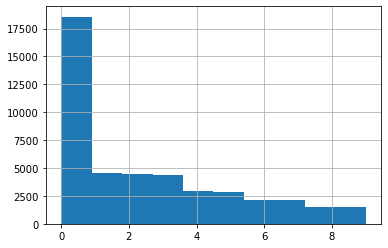

In [48]:
df.joke_mark.hist()

In [13]:
df.rename(columns={'joke_text': 'joke', 'joke_mark': 'mark'}) \
    [['joke', 'mark']] \
    .to_csv('../data/parsed-stat-dataset/stat-dataset.csv', sep=';', index=False)

In [39]:
df = pd.read_csv('../data/parsed-stat-dataset/stat-dataset.csv', sep=';')
df[['joke']].to_csv('../data/agg-complete-text-dataset/stat-dataset.csv', index=False)
df[['joke', 'mark']].to_csv('../data/agg-marked-joke-dataset/stat-dataset.csv', index=False)

## Anecdote dataset

Anecdotes were parsed with selenium from site. With mark for each joke.

In [66]:
import pandas as pd

In [67]:
df = pd.read_csv('../data/anecdote-dataset/anecdote_dataset.tsv', sep='\t')
# Mark binarization
df.likes = pd.qcut(df.likes, 10, labels=False, duplicates='drop')
df.shape

(82900, 2)

In [68]:
df.head()

,joke_text,likes
0,- Все проблемы в Думе решит Максим.\n- Это кто...,8
1,"Муж с женой в постели. Жена спит, мужу не спит...",7
2,Никогда не забывай свои корни! Постоянно закра...,7
3,"- Скажите, вы - натуральная блондинка?\n- Ммм....",5
4,Ходил с друзьями на курсы по избавлению от мат...,5


<AxesSubplot:>

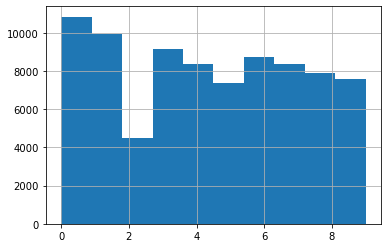

In [69]:
df.likes.hist()

In [70]:
df.rename(columns={'joke_text': 'joke', 'likes': 'mark'}) \
    [['joke', 'mark']] \
    .to_csv('../data/anecdote-dataset/anecdote_dataset_bin.tsv', sep='\t', index=False)

In [40]:
df = pd.read_csv('../data/anecdote-dataset/anecdote_dataset_bin.tsv', sep='\t')
df[['joke']].to_csv('../data/agg-complete-text-dataset/anecdote-dataset.csv', index=False)
df[['joke', 'mark']].to_csv('../data/agg-marked-joke-dataset/anecdote-dataset.csv', index=False)

## KVN

In [47]:
df = pd.read_csv('../data/kvn-dataset/kvn_dataset.tsv', sep='\t')
df = df.rename(columns={'joke_text': 'joke'})

In [49]:
df[['joke']].to_csv('../data/agg-complete-text-dataset/kvn-dataset.csv', index=False)

# Join datasets

In [55]:
import pandas as pd
import numpy as np
import re
import plotly.express as px
import glob
import os

## Complete jokes dataset

Concatenation of different datasets into one dataset.
Trying to split jokes into setup-punch pairs. If split is impossible, then save complete joke.

In [81]:
file_names = ['stat-dataset.csv',
              'reddit-dataset.csv',
              'anecdote-dataset.csv',
              'wocka-dataset.csv',
              'tweeter-dataset.csv',
              'kvn-dataset.csv']
preffix = '../data/agg-complete-text-dataset/'

In [82]:
complete_joke_df = pd.DataFrame()
for file_name in file_names:
    file_path = os.path.join(preffix, file_name)
    temp_df = pd.read_csv(file_path)
    assert 'joke' in temp_df.columns.tolist()
    complete_joke_df = pd.concat([complete_joke_df, temp_df], axis=0)
complete_joke_df = complete_joke_df.reset_index(drop=True)
complete_joke_df.shape

(336761, 1)

In [83]:
# Clean
def remove_special_tokens(text):
    result = ''
    try:
        result = re.sub(r'\r|\n|\t', '', text)
    except:
        pass
    return result

complete_joke_df.joke = complete_joke_df.joke.apply(remove_special_tokens)
complete_joke_df = complete_joke_df.drop_duplicates(subset=['joke'])
complete_joke_df.shape

(317045, 1)

In [84]:
complete_joke_df.sample(5)

,joke
140232,Повара в нашей столовой действуют по принципу:...
146328,"- Ну, ты прямо как муравей!- Почему?- Да посто..."
104099,- Ты меня слушаешь? Вот что я сейчас сказала?!...
30699,У мужика в клетке жил попугай. И вот у этого п...
140047,Для собственного благополучия надо уметь: закр...


px.histogram(complete_joke_df.joke.str.len())

### Try to find setup and punch in complete joke

In [85]:
def setup_punch_split(text):
    parts = re.split(r'\.{3}|\.|\?|\!|:', text)
    
    if (len(parts) > 3) or (len(parts) < 2):
        return None
    
    if (len(parts[-1]) == 0):
        parts = parts[:-1]
        
    if (len(parts) == 2) and (len(parts[0]) > 10) and (len(parts[1]) > 10):
        return (parts[0].strip(), parts[1].strip())

In [86]:
punch_setup_df = complete_joke_df.copy()
punch_setup_df['setup_punch'] = punch_setup_df.joke.apply(setup_punch_split)
punch_setup_df = punch_setup_df.loc[~punch_setup_df.setup_punch.isna()]
punch_setup_df = pd.DataFrame(punch_setup_df.setup_punch.tolist(), columns=['setup', 'punch'])
punch_setup_df.shape

(71505, 2)

In [87]:
# Remove setup-punch from complete dataset
complete_joke_df = complete_joke_df.loc[~complete_joke_df.index.isin(punch_setup_df.index)]
complete_joke_df.shape

(258887, 1)

In [88]:
# Save
punch_setup_df.to_csv('../data/agg-setup-punch-dataset/setup-punch-from-complete-jokes.csv', index=False)
complete_joke_df.to_csv('../data/agg-complete-text-dataset/agg-complete-text-dataset.csv', index=False)

## Setup-punch datasets

Concatenate setup-punch datasets together and clean text.

In [91]:
file_names = ['comedy-news-tg.csv',
              'setup-punch-from-complete-jokes.csv']
preffix = '../data/agg-setup-punch-dataset/'

In [93]:
setup_punch_df = pd.DataFrame()
for file_name in file_names:
    file_path = os.path.join(preffix, file_name)
    temp_df = pd.read_csv(file_path)
    assert 'setup' in temp_df.columns.tolist()
    assert 'punch' in temp_df.columns.tolist()
    setup_punch_df = pd.concat([setup_punch_df, temp_df], axis=0)
setup_punch_df = setup_punch_df.reset_index(drop=True)
setup_punch_df.shape

(86901, 2)

In [94]:
# Clean
def remove_special_tokens(text):
    result = ''
    try:
        result = re.sub(r'\r|\n|\t', '', text)
    except:
        pass
    return result

setup_punch_df.setup = setup_punch_df.setup.apply(remove_special_tokens)
setup_punch_df.punch = setup_punch_df.punch.apply(remove_special_tokens)

setup_punch_df = setup_punch_df.drop_duplicates(subset=['setup']).dropna()

setup_punch_df = setup_punch_df.loc[setup_punch_df.setup.str.len() > 10]
setup_punch_df = setup_punch_df.loc[setup_punch_df.punch.str.len() > 0]

setup_punch_df.shape

(67480, 2)

In [95]:
setup_punch_df.sample(5)

,setup,punch
83037,"Все такие нежные, как цветочки, или заводные к...","Никого пальцем не тронь, или помнутся, или пол..."
79622,Жизнь — бумеранг,"что запустишь, то и вернётся, ещё и вдвойне"
63878,"Неважно, господа, обстоят дела у Грузии, неважно",Так вслед за двумя тысячами своих вояк выводим...
83253,Коммунисты согласились похоронить Ленина,но только вместе со всем Кремлевским комплексом
73950,"Продолжает мучить вопрос про футбол, хоккей и ...",Что-же все-таки нашли - золотую рыбку или волш...


px.histogram(setup_punch_df.setup.str.len())

px.histogram(setup_punch_df.punch.str.len())

In [96]:
setup_punch_df.to_csv('../data/agg-setup-punch-dataset/agg-setup-punch-dataset.csv', index=False)

## Marked jokes dataset

In [98]:
file_names = ['stat-dataset.csv',
              'anecdote-dataset.csv',
              'comedy-news-tg.csv']
preffix = '../data/agg-marked-joke-dataset/'

In [99]:
marked_joke_df = pd.DataFrame()
for file_name in file_names:
    file_path = os.path.join(preffix, file_name)
    temp_df = pd.read_csv(file_path)
    assert 'joke' in temp_df.columns.tolist()
    assert 'mark' in temp_df.columns.tolist()
    marked_joke_df = pd.concat([marked_joke_df, temp_df], axis=0)
marked_joke_df = marked_joke_df.reset_index(drop=True)
marked_joke_df.shape

(143292, 2)

Concatenation of datasets with joke and mark

In [100]:
# Clean
def remove_special_tokens(text):
    result = ''
    try:
        result = re.sub(r'\r|\n|\t', '', text)
    except:
        pass
    return result

marked_joke_df.joke = marked_joke_df.joke.apply(remove_special_tokens)
marked_joke_df = marked_joke_df.drop_duplicates(subset=['joke']).dropna()
marked_joke_df.shape

(130321, 2)

In [101]:
marked_joke_df.sample(5)

,joke,mark
48471,Найти работу и наладить личную жизнь ты всегда...,7
31488,"Как называется город, где живут одни карлики?S...",0
141875,Билл Гейтс предупредил о пандемии страшнее кор...,5
121799,"Медицине известен факт, что женатые живут доль...",6
94161,"- Новый год - это же волшебный праздник, ну ка...",0


In [102]:
marked_joke_df.to_csv('../data/agg-marked-joke-dataset/agg-marked-joke-dataset.csv', index=False)

# Generation dataset

In [159]:
inspiration_prefix = 'Сгенерировать вдохновение: '
mark_prefix = 'Сгенерировать оценку: '
punch_prefix = 'Сгенерировать шутку: '

In [160]:
import pandas as pd
import spacy
from multi_rake import Rake
rake = Rake(language_code='ru')
nlp = spacy.load("ru_core_news_md")
def get_inspiration(text):
    keywords = rake.apply(text)
    if len(keywords) == 0:
        return ''
    keyword = keywords[0][0]
    lem_keywords = [token.lemma_ for token in nlp(keyword)]
    return ' '.join(lem_keywords)

In [161]:
marked_joke_df_ = pd.read_csv('../data/agg-marked-joke-dataset/agg-marked-joke-dataset.csv')
setup_punch_df_ = pd.read_csv('../data/agg-setup-punch-dataset/agg-setup-punch-dataset.csv')

In [162]:
# Generate inspiration
setup_punch_df_['inspiration'] = setup_punch_df_['punch'].progress_apply(get_inspiration)

100%|██████████| 67480/67480 [03:18<00:00, 340.52it/s]


In [163]:
# Inspiration
inspiration_df = setup_punch_df_.copy()
inspiration_df['input'] = inspiration_prefix + inspiration_df['setup']
inspiration_df['output'] = inspiration_df['inspiration']

# Punch
setup_punch_df = setup_punch_df_.copy()
setup_punch_df['input'] = punch_prefix + setup_punch_df['inspiration'] + '|' + setup_punch_df['setup']
setup_punch_df['output'] = setup_punch_df['punch']

# Mark
marked_joke_df = marked_joke_df_.copy()
marked_joke_df['input'] = mark_prefix + marked_joke_df['joke']
marked_joke_df['output'] = marked_joke_df['mark']
# Reduce size and simplify task
marked_joke_df = marked_joke_df.loc[marked_joke_df.output.isin([0, 1, 8, 9])]
marked_joke_df.output = np.where(marked_joke_df.output <= 1, 'плохо', 'хорошо')

In [164]:
marked_joke_df.output.value_counts()

плохо     50373
хорошо    17645
Name: output, dtype: int64

In [165]:
generation_df = pd.concat([inspiration_df[['input', 'output']],
                           setup_punch_df[['input', 'output']],
                           marked_joke_df[['input', 'output']]], axis=0).sample(frac=1)
generation_df = generation_df.loc[generation_df.output.str.len() > 0]
generation_df = generation_df.loc[generation_df.input.str.len() > 0]

In [166]:
generation_df.input.str.split(':').str[0].value_counts()

Сгенерировать оценку         68018
Сгенерировать шутку          67480
Сгенерировать вдохновение    65142
Name: input, dtype: int64

In [168]:
generation_df.sample(5)

,input,output
32869,Сгенерировать оценку: Человек должен не слышат...,хорошо
61750,Сгенерировать шутку: плохо пошутить|Мы с друзь...,"Так что, если вы плохо пошутили, то просто гов..."
82351,"Сгенерировать оценку: - Сарочка, скажите, а чт...",плохо
9622,Сгенерировать вдохновение: Есть два вида перво...,весёлый
7447,Сгенерировать шутку: отделаться шлепок|Садомаз...,он отделался шлепком по запястью


In [169]:
generation_df.to_csv('../data/agg-generation-dataset/agg-generation-dataset.csv', index=False)
split = np.random.choice([0, 1, 2], p=[0.9, 0.08, 0.02], size=len(generation_df))
generation_df.iloc[split == 0].to_csv('../data/agg-generation-dataset/agg-generation-dataset-train.csv', index=False)
generation_df.iloc[split == 1].to_csv('../data/agg-generation-dataset/agg-generation-dataset-valid.csv', index=False)
generation_df.iloc[split == 2].to_csv('../data/agg-generation-dataset/agg-generation-dataset-test.csv', index=False)